# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com media=0 e stddev=sqrt(3.0 / (out + inp)). Ver notas de np.random.randn.
    std_dev = np.sqrt(3.0 / (rows + cols))
    return std_dev*np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], onde limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

###### Dos Pesos

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return [np.where(w > 0, 1, w) for w in weights]
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return np.sum([0.5*np.sum(w**2) for w in weights])

# Implementação 

In [12]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self._activ_inp, self._activ_out = None, None
        self.dweights, self.dbiases = None, None       

class NeuralNetwork():
    def __init__(self, cost_func, learning_rate=1e-3, reg_func=l2_regularization, reg_strength=0.0):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        
    def fit(self, x, y, epochs=100, verbose=10):
        for epoch in range(epochs+1):
            y_pred = self.__feedforward(x)
            self.__backprop(y, y_pred)
            
            if epoch % verbose == 0:
                data_loss = self.cost_func(y, y_pred)/x.shape[0]
                reg_loss = self.reg_strength*self.reg_func([layer.weights for layer in self.layers])
                print("epoch: {0:=4}/{1} data_loss:{2:.8f} reg_loss:{3:.8f} cost:{4:.8f}".format(epoch, epochs, data_loss, reg_loss, data_loss + reg_loss))
        
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:]+[Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, layer.weights)
            layer.dweights = np.dot(dactivation.T, layer.input)
            layer.dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        dregularization = self.reg_func([layer.weights for layer in self.layers], derivative=True)
        for layer, dreg in zip(reversed(self.layers), reversed(dregularization)):
            layer.dweights = layer.dweights + self.reg_strength*dreg
            layer.weights = layer.weights - self.learning_rate*layer.dweights
            layer.biases = layer.biases - self.learning_rate*layer.dbiases

# Testes da Implementação

## Exemplos do Notebook da Intuição

### Exemplo 1

In [13]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 data_loss:0.29837111 reg_loss:0.00000000 cost:0.29837111
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


### Exemplo 2

In [14]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 data_loss:1.16744561 reg_loss:0.00000000 cost:1.16744561
epoch:   30/300 data_loss:0.60797958 reg_loss:0.00000000 cost:0.60797958
epoch:   60/300 data_loss:0.36558760 reg_loss:0.00000000 cost:0.36558760
epoch:   90/300 data_loss:0.24943452 reg_loss:0.00000000 cost:0.24943452
epoch:  120/300 data_loss:0.18547915 reg_loss:0.00000000 cost:0.18547915
epoch:  150/300 data_loss:0.14614615 reg_loss:0.00000000 cost:0.14614615
epoch:  180/300 data_loss:0.11990516 reg_loss:0.00000000 cost:0.11990516
epoch:  210/300 data_loss:0.10131084 reg_loss:0.00000000 cost:0.10131084
epoch:  240/300 data_loss:0.08751844 reg_loss:0.00000000 cost:0.08751844
epoch:  270/300 data_loss:0.07691721 reg_loss:0.00000000 cost:0.07691721
epoch:  300/300 data_loss:0.06853445 reg_loss:0.00000000 cost:0.06853445
[[ 0.10083595  0.2016719   0.30585165]
 [ 0.30086971  0.20173942  0.70608796]
 [ 0.40145052  0.30290104  0.91015363]]
[[ 0.20544723  0.30673159  0.50749567]
 [ 0.30994562  0.5123005   0.71366784]
 

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [15]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [16]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 1.0


epoch:    0/1000 data_loss:55.95635537 reg_loss:0.00000000 cost:55.95635537
epoch:  100/1000 data_loss:0.31036230 reg_loss:0.00000000 cost:0.31036230
epoch:  200/1000 data_loss:0.26196701 reg_loss:0.00000000 cost:0.26196701
epoch:  300/1000 data_loss:0.26085528 reg_loss:0.00000000 cost:0.26085528
epoch:  400/1000 data_loss:0.26082975 reg_loss:0.00000000 cost:0.26082975
epoch:  500/1000 data_loss:0.26082916 reg_loss:0.00000000 cost:0.26082916
epoch:  600/1000 data_loss:0.26082915 reg_loss:0.00000000 cost:0.26082915
epoch:  700/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
epoch:  800/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
epoch:  900/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
epoch: 1000/1000 data_loss:0.26082914 reg_loss:0.00000000 cost:0.26082914
[[ 33.60164745]]
[[ 74.99636286]]


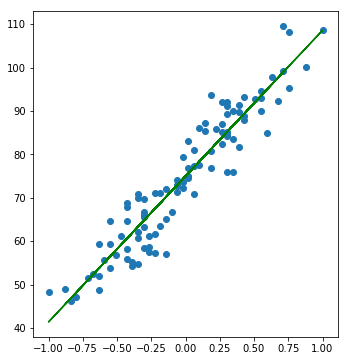

In [18]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [19]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [ 1.  1.  1.]


In [21]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 data_loss:1062.86944100 reg_loss:0.00000000 cost:1062.86944100
epoch:  200/2000 data_loss:0.27347277 reg_loss:0.00000000 cost:0.27347277
epoch:  400/2000 data_loss:0.23284528 reg_loss:0.00000000 cost:0.23284528
epoch:  600/2000 data_loss:0.22988808 reg_loss:0.00000000 cost:0.22988808
epoch:  800/2000 data_loss:0.22955973 reg_loss:0.00000000 cost:0.22955973
epoch: 1000/2000 data_loss:0.22951842 reg_loss:0.00000000 cost:0.22951842
epoch: 1200/2000 data_loss:0.22951308 reg_loss:0.00000000 cost:0.22951308
epoch: 1400/2000 data_loss:0.22951239 reg_loss:0.00000000 cost:0.22951239
epoch: 1600/2000 data_loss:0.22951230 reg_loss:0.00000000 cost:0.22951230
epoch: 1800/2000 data_loss:0.22951229 reg_loss:0.00000000 cost:0.22951229
epoch: 2000/2000 data_loss:0.22951229 reg_loss:0.00000000 cost:0.22951229
[[  8.72090603  14.10521705  26.26733428]]
[[ 150.65173418]]


### Regressão Quadrática

In [22]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [23]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 data_loss:23.32634904 reg_loss:0.00000000 cost:23.32634904
epoch: 1000/10000 data_loss:1.33679722 reg_loss:0.00000000 cost:1.33679722
epoch: 2000/10000 data_loss:0.49377147 reg_loss:0.00000000 cost:0.49377147
epoch: 3000/10000 data_loss:0.34277746 reg_loss:0.00000000 cost:0.34277746
epoch: 4000/10000 data_loss:0.30109084 reg_loss:0.00000000 cost:0.30109084
epoch: 5000/10000 data_loss:0.28662028 reg_loss:0.00000000 cost:0.28662028
epoch: 6000/10000 data_loss:0.28061411 reg_loss:0.00000000 cost:0.28061411
epoch: 7000/10000 data_loss:0.27754376 reg_loss:0.00000000 cost:0.27754376
epoch: 8000/10000 data_loss:0.27561323 reg_loss:0.00000000 cost:0.27561323
epoch: 9000/10000 data_loss:0.27418721 reg_loss:0.00000000 cost:0.27418721
epoch: 10000/10000 data_loss:0.27302675 reg_loss:0.00000000 cost:0.27302675


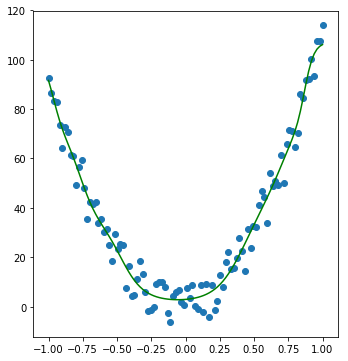

In [24]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [25]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [26]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 data_loss:1.00778841 reg_loss:0.00000000 cost:1.00778841
epoch: 1000/10000 data_loss:0.64559646 reg_loss:0.00000000 cost:0.64559646
epoch: 2000/10000 data_loss:0.25385229 reg_loss:0.00000000 cost:0.25385229
epoch: 3000/10000 data_loss:0.09040235 reg_loss:0.00000000 cost:0.09040235
epoch: 4000/10000 data_loss:0.06063321 reg_loss:0.00000000 cost:0.06063321
epoch: 5000/10000 data_loss:0.04916980 reg_loss:0.00000000 cost:0.04916980
epoch: 6000/10000 data_loss:0.04288160 reg_loss:0.00000000 cost:0.04288160
epoch: 7000/10000 data_loss:0.03918868 reg_loss:0.00000000 cost:0.03918868
epoch: 8000/10000 data_loss:0.03687684 reg_loss:0.00000000 cost:0.03687684
epoch: 9000/10000 data_loss:0.03533038 reg_loss:0.00000000 cost:0.03533038
epoch: 10000/10000 data_loss:0.03420169 reg_loss:0.00000000 cost:0.03420169


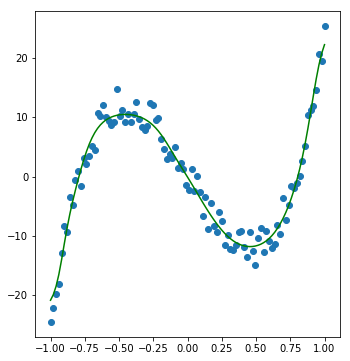

In [27]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [28]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [29]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 data_loss:0.03818294 reg_loss:0.00000000 cost:0.03818294
epoch: 1000/10000 data_loss:0.00058751 reg_loss:0.00000000 cost:0.00058751
epoch: 2000/10000 data_loss:0.00046467 reg_loss:0.00000000 cost:0.00046467
epoch: 3000/10000 data_loss:0.00042818 reg_loss:0.00000000 cost:0.00042818
epoch: 4000/10000 data_loss:0.00040892 reg_loss:0.00000000 cost:0.00040892
epoch: 5000/10000 data_loss:0.00039598 reg_loss:0.00000000 cost:0.00039598
epoch: 6000/10000 data_loss:0.00038628 reg_loss:0.00000000 cost:0.00038628
epoch: 7000/10000 data_loss:0.00037862 reg_loss:0.00000000 cost:0.00037862
epoch: 8000/10000 data_loss:0.00037243 reg_loss:0.00000000 cost:0.00037243
epoch: 9000/10000 data_loss:0.00036735 reg_loss:0.00000000 cost:0.00036735
epoch: 10000/10000 data_loss:0.00036312 reg_loss:0.00000000 cost:0.00036312


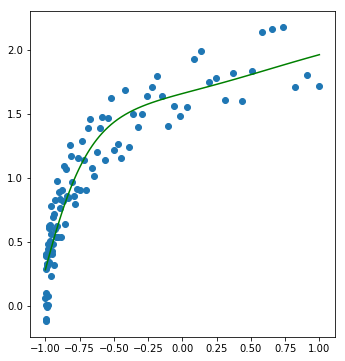

In [30]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-4)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [31]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [32]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 data_loss:34.55295531 reg_loss:0.00000000 cost:34.55295531
epoch: 1000/10000 data_loss:0.36116924 reg_loss:0.00000000 cost:0.36116924
epoch: 2000/10000 data_loss:0.34209463 reg_loss:0.00000000 cost:0.34209463
epoch: 3000/10000 data_loss:0.34116615 reg_loss:0.00000000 cost:0.34116615
epoch: 4000/10000 data_loss:0.34034740 reg_loss:0.00000000 cost:0.34034740
epoch: 5000/10000 data_loss:0.33963920 reg_loss:0.00000000 cost:0.33963920
epoch: 6000/10000 data_loss:0.33907518 reg_loss:0.00000000 cost:0.33907518
epoch: 7000/10000 data_loss:0.33864507 reg_loss:0.00000000 cost:0.33864507
epoch: 8000/10000 data_loss:0.33833425 reg_loss:0.00000000 cost:0.33833425
epoch: 9000/10000 data_loss:0.33811717 reg_loss:0.00000000 cost:0.33811717
epoch: 10000/10000 data_loss:0.33798759 reg_loss:0.00000000 cost:0.33798759


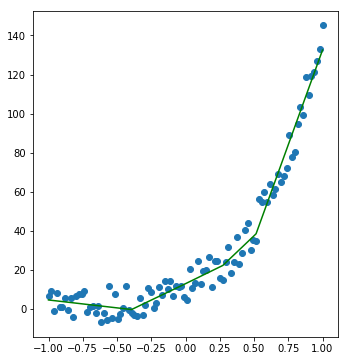

In [33]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [34]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 data_loss:0.28367194 reg_loss:0.03182674 cost:0.31549868
epoch: 1000/5000 data_loss:0.07160600 reg_loss:0.15234694 cost:0.22395294
epoch: 2000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
epoch: 3000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
epoch: 4000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
epoch: 5000/5000 data_loss:0.07160599 reg_loss:0.15234696 cost:0.22395296
[[ 1.52346962  1.52346962]] [[-2.63959782]]
[[ 0.06663304]
 [ 0.24673017]
 [ 0.24673017]
 [ 0.60045023]]


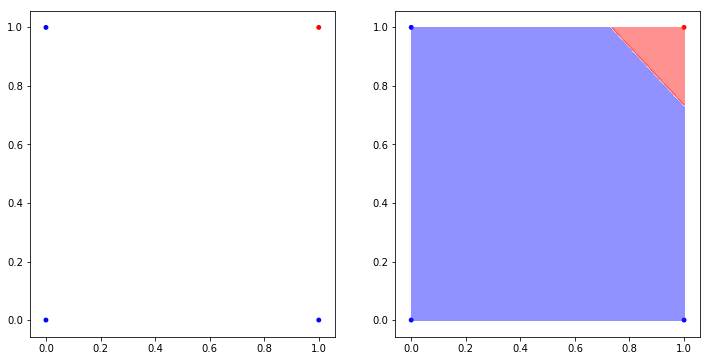

In [41]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0, reg_func=l1_regularization, reg_strength=0.05)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.layers[0].weights, nn.layers[0].biases)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [42]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 data_loss:0.26062340 reg_loss:0.00000000 cost:0.26062340
epoch: 1000/5000 data_loss:0.01278909 reg_loss:0.00000000 cost:0.01278909
epoch: 2000/5000 data_loss:0.00745504 reg_loss:0.00000000 cost:0.00745504
epoch: 3000/5000 data_loss:0.00573328 reg_loss:0.00000000 cost:0.00573328
epoch: 4000/5000 data_loss:0.00481648 reg_loss:0.00000000 cost:0.00481648
epoch: 5000/5000 data_loss:0.00422777 reg_loss:0.00000000 cost:0.00422777
[[ 0.01656993]
 [ 0.98091624]
 [ 0.98391616]
 [ 0.01532631]]


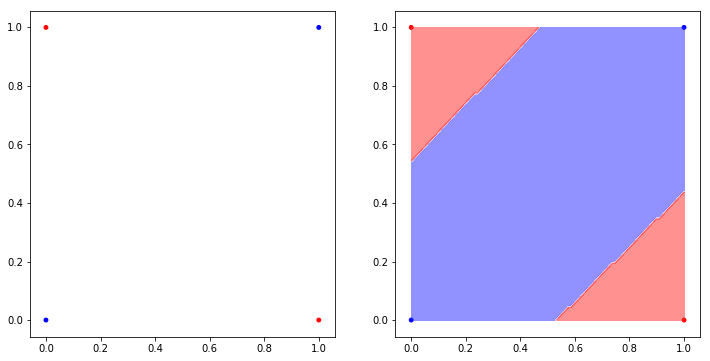

In [43]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

In [44]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 data_loss:0.03068629 reg_loss:0.00000000 cost:0.03068629
epoch: 1000/5000 data_loss:0.00040922 reg_loss:0.00000000 cost:0.00040922
epoch: 2000/5000 data_loss:0.00025534 reg_loss:0.00000000 cost:0.00025534
epoch: 3000/5000 data_loss:0.00019847 reg_loss:0.00000000 cost:0.00019847
epoch: 4000/5000 data_loss:0.00016670 reg_loss:0.00000000 cost:0.00016670
epoch: 5000/5000 data_loss:0.00014577 reg_loss:0.00000000 cost:0.00014577


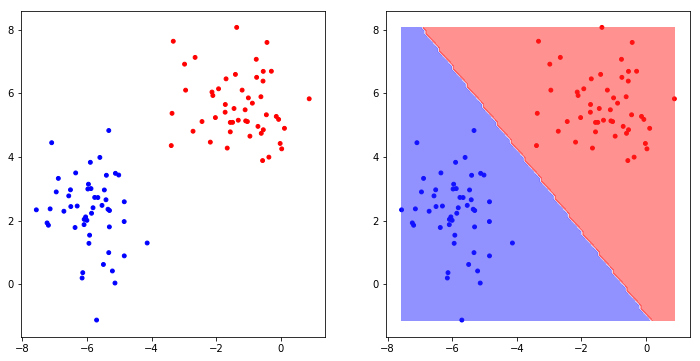

In [45]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

In [46]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/5000 data_loss:0.00886587 reg_loss:0.00000000 cost:0.00886587
epoch: 1000/5000 data_loss:0.00667074 reg_loss:0.00000000 cost:0.00667074
epoch: 2000/5000 data_loss:0.00011447 reg_loss:0.00000000 cost:0.00011447
epoch: 3000/5000 data_loss:0.00001549 reg_loss:0.00000000 cost:0.00001549
epoch: 4000/5000 data_loss:0.00001037 reg_loss:0.00000000 cost:0.00001037
epoch: 5000/5000 data_loss:0.00000813 reg_loss:0.00000000 cost:0.00000813


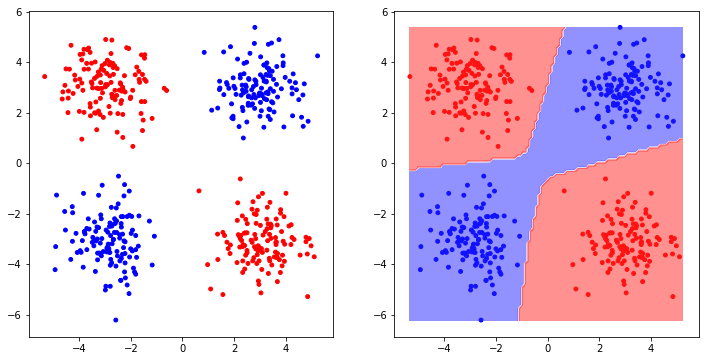

In [47]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [48]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/10000 data_loss:0.00305304 reg_loss:0.00000000 cost:0.00305304
epoch: 1000/10000 data_loss:0.00007948 reg_loss:0.00000000 cost:0.00007948
epoch: 2000/10000 data_loss:0.00003733 reg_loss:0.00000000 cost:0.00003733
epoch: 3000/10000 data_loss:0.00002536 reg_loss:0.00000000 cost:0.00002536
epoch: 4000/10000 data_loss:0.00001945 reg_loss:0.00000000 cost:0.00001945
epoch: 5000/10000 data_loss:0.00001598 reg_loss:0.00000000 cost:0.00001598
epoch: 6000/10000 data_loss:0.00001364 reg_loss:0.00000000 cost:0.00001364
epoch: 7000/10000 data_loss:0.00001194 reg_loss:0.00000000 cost:0.00001194
epoch: 8000/10000 data_loss:0.00001067 reg_loss:0.00000000 cost:0.00001067
epoch: 9000/10000 data_loss:0.00000968 reg_loss:0.00000000 cost:0.00000968
epoch: 10000/10000 data_loss:0.00000888 reg_loss:0.00000000 cost:0.00000888


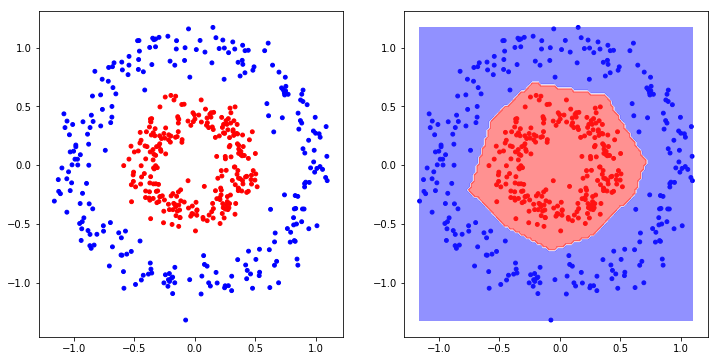

In [49]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [50]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 data_loss:0.00398994 reg_loss:0.00000000 cost:0.00398994
epoch: 2000/20000 data_loss:0.00117626 reg_loss:0.00000000 cost:0.00117626
epoch: 4000/20000 data_loss:0.00074576 reg_loss:0.00000000 cost:0.00074576
epoch: 6000/20000 data_loss:0.00054199 reg_loss:0.00000000 cost:0.00054199
epoch: 8000/20000 data_loss:0.00044622 reg_loss:0.00000000 cost:0.00044622
epoch: 10000/20000 data_loss:0.00039200 reg_loss:0.00000000 cost:0.00039200
epoch: 12000/20000 data_loss:0.00035712 reg_loss:0.00000000 cost:0.00035712
epoch: 14000/20000 data_loss:0.00033264 reg_loss:0.00000000 cost:0.00033264
epoch: 16000/20000 data_loss:0.00031439 reg_loss:0.00000000 cost:0.00031439
epoch: 18000/20000 data_loss:0.00030019 reg_loss:0.00000000 cost:0.00030019
epoch: 20000/20000 data_loss:0.00028878 reg_loss:0.00000000 cost:0.00028878


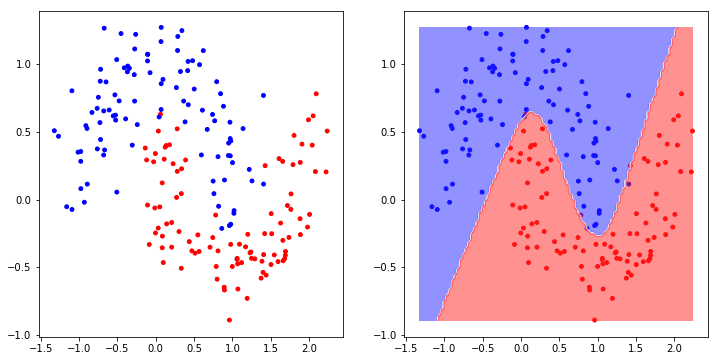

In [51]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=tanh))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=20000, verbose=2000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [52]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 data_loss:0.00569759 reg_loss:0.00000000 cost:0.00569759
epoch: 2000/20000 data_loss:0.00209062 reg_loss:0.00000000 cost:0.00209062
epoch: 4000/20000 data_loss:0.00136639 reg_loss:0.00000000 cost:0.00136639
epoch: 6000/20000 data_loss:0.00102784 reg_loss:0.00000000 cost:0.00102784
epoch: 8000/20000 data_loss:0.00080601 reg_loss:0.00000000 cost:0.00080601
epoch: 10000/20000 data_loss:0.00063902 reg_loss:0.00000000 cost:0.00063902
epoch: 12000/20000 data_loss:0.00051845 reg_loss:0.00000000 cost:0.00051845
epoch: 14000/20000 data_loss:0.00043003 reg_loss:0.00000000 cost:0.00043003
epoch: 16000/20000 data_loss:0.00036580 reg_loss:0.00000000 cost:0.00036580
epoch: 18000/20000 data_loss:0.00032505 reg_loss:0.00000000 cost:0.00032505
epoch: 20000/20000 data_loss:0.00029524 reg_loss:0.00000000 cost:0.00029524


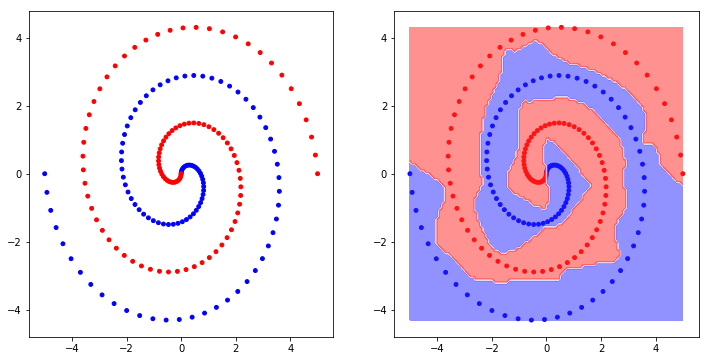

In [61]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=20000, verbose=2000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [62]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [63]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


epoch:    0/10000 data_loss:0.01337245 reg_loss:0.39925356 cost:0.41262601
epoch: 1000/10000 data_loss:0.00064931 reg_loss:0.17902453 cost:0.17967384
epoch: 2000/10000 data_loss:0.00043514 reg_loss:0.17157381 cost:0.17200895
epoch: 3000/10000 data_loss:0.00036536 reg_loss:0.17293520 cost:0.17330056
epoch: 4000/10000 data_loss:0.00033053 reg_loss:0.17437307 cost:0.17470360
epoch: 5000/10000 data_loss:0.00031183 reg_loss:0.17439711 cost:0.17470894
epoch: 6000/10000 data_loss:0.00030041 reg_loss:0.17375164 cost:0.17405205
epoch: 7000/10000 data_loss:0.00029115 reg_loss:0.17340168 cost:0.17369283
epoch: 8000/10000 data_loss:0.00028517 reg_loss:0.17263437 cost:0.17291954
epoch: 9000/10000 data_loss:0.00027875 reg_loss:0.17250630 cost:0.17278505
epoch: 10000/10000 data_loss:0.00027463 reg_loss:0.17208901 cost:0.17236364
[[-0.17419074 -0.8142649 ]
 [-0.88560499  0.27173392]]
[[ 0.76174925 -0.19253387]
 [-0.20736456  0.76856727]
 [-0.55451506 -0.57598709]]


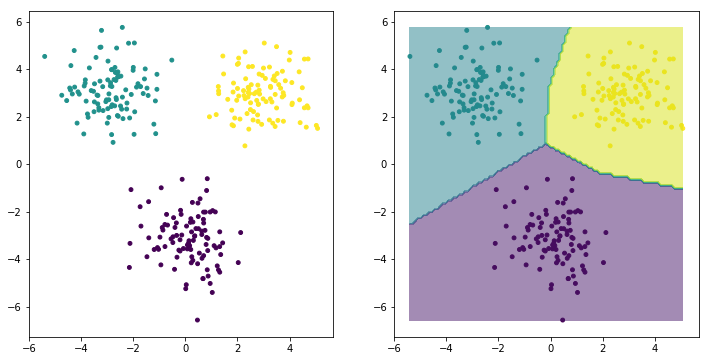

In [67]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, reg_func=l2_regularization, reg_strength=0.1)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

for layer in nn.layers:
    print(layer.weights)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [68]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [69]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


epoch:    0/10000 data_loss:0.01129857 reg_loss:0.00000000 cost:0.01129857
epoch: 1000/10000 data_loss:0.00052265 reg_loss:0.00000000 cost:0.00052265
epoch: 2000/10000 data_loss:0.00035130 reg_loss:0.00000000 cost:0.00035130
epoch: 3000/10000 data_loss:0.00029027 reg_loss:0.00000000 cost:0.00029027
epoch: 4000/10000 data_loss:0.00026026 reg_loss:0.00000000 cost:0.00026026
epoch: 5000/10000 data_loss:0.00024273 reg_loss:0.00000000 cost:0.00024273
epoch: 6000/10000 data_loss:0.00023134 reg_loss:0.00000000 cost:0.00023134
epoch: 7000/10000 data_loss:0.00022327 reg_loss:0.00000000 cost:0.00022327
epoch: 8000/10000 data_loss:0.00021740 reg_loss:0.00000000 cost:0.00021740
epoch: 9000/10000 data_loss:0.00021289 reg_loss:0.00000000 cost:0.00021289
epoch: 10000/10000 data_loss:0.00020929 reg_loss:0.00000000 cost:0.00020929


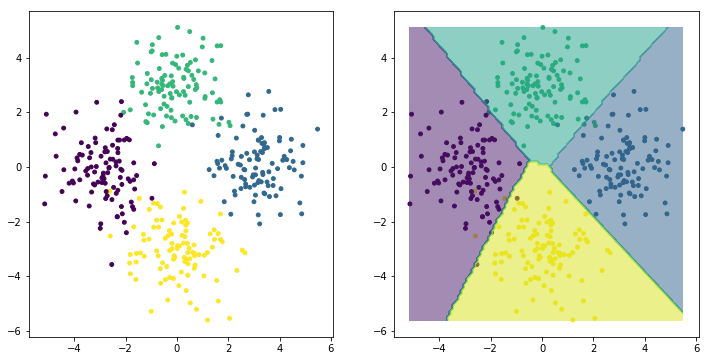

In [70]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [71]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [72]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


epoch:    0/10000 data_loss:0.04546778 reg_loss:0.00000000 cost:0.04546778
epoch: 1000/10000 data_loss:0.00062249 reg_loss:0.00000000 cost:0.00062249
epoch: 2000/10000 data_loss:0.00030746 reg_loss:0.00000000 cost:0.00030746
epoch: 3000/10000 data_loss:0.00016152 reg_loss:0.00000000 cost:0.00016152
epoch: 4000/10000 data_loss:0.00011241 reg_loss:0.00000000 cost:0.00011241
epoch: 5000/10000 data_loss:0.00009111 reg_loss:0.00000000 cost:0.00009111
epoch: 6000/10000 data_loss:0.00007912 reg_loss:0.00000000 cost:0.00007912
epoch: 7000/10000 data_loss:0.00007116 reg_loss:0.00000000 cost:0.00007116
epoch: 8000/10000 data_loss:0.00006553 reg_loss:0.00000000 cost:0.00006553
epoch: 9000/10000 data_loss:0.00006123 reg_loss:0.00000000 cost:0.00006123
epoch: 10000/10000 data_loss:0.00005789 reg_loss:0.00000000 cost:0.00005789


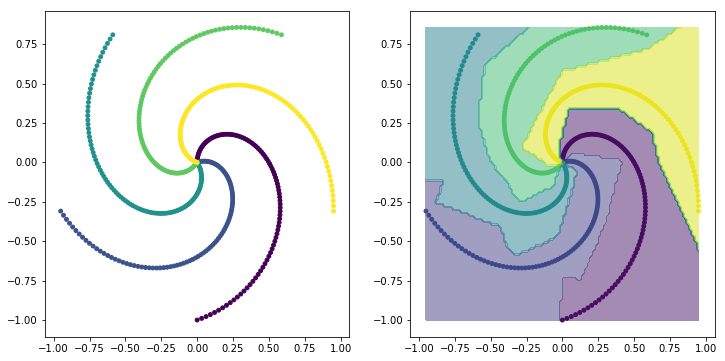

In [73]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [74]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [75]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


epoch:    0/10000 data_loss:0.04708722 reg_loss:0.00000000 cost:0.04708722
epoch: 1000/10000 data_loss:0.00363278 reg_loss:0.00000000 cost:0.00363278
epoch: 2000/10000 data_loss:0.00282900 reg_loss:0.00000000 cost:0.00282900
epoch: 3000/10000 data_loss:0.00253274 reg_loss:0.00000000 cost:0.00253274
epoch: 4000/10000 data_loss:0.00236240 reg_loss:0.00000000 cost:0.00236240
epoch: 5000/10000 data_loss:0.00224283 reg_loss:0.00000000 cost:0.00224283
epoch: 6000/10000 data_loss:0.00214668 reg_loss:0.00000000 cost:0.00214668
epoch: 7000/10000 data_loss:0.00207325 reg_loss:0.00000000 cost:0.00207325
epoch: 8000/10000 data_loss:0.00200909 reg_loss:0.00000000 cost:0.00200909
epoch: 9000/10000 data_loss:0.00195119 reg_loss:0.00000000 cost:0.00195119
epoch: 10000/10000 data_loss:0.00189965 reg_loss:0.00000000 cost:0.00189965


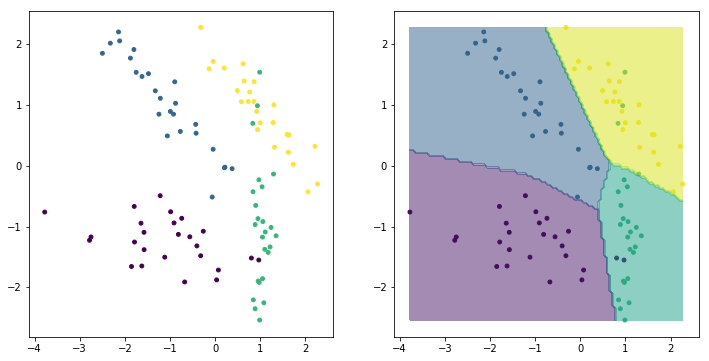

In [76]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [77]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [78]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


epoch:    0/10000 data_loss:0.03717461 reg_loss:0.00000000 cost:0.03717461
epoch: 1000/10000 data_loss:0.00389044 reg_loss:0.00000000 cost:0.00389044
epoch: 2000/10000 data_loss:0.00276119 reg_loss:0.00000000 cost:0.00276119
epoch: 3000/10000 data_loss:0.00232248 reg_loss:0.00000000 cost:0.00232248
epoch: 4000/10000 data_loss:0.00205451 reg_loss:0.00000000 cost:0.00205451
epoch: 5000/10000 data_loss:0.00184438 reg_loss:0.00000000 cost:0.00184438
epoch: 6000/10000 data_loss:0.00166100 reg_loss:0.00000000 cost:0.00166100
epoch: 7000/10000 data_loss:0.00149437 reg_loss:0.00000000 cost:0.00149437
epoch: 8000/10000 data_loss:0.00134712 reg_loss:0.00000000 cost:0.00134712
epoch: 9000/10000 data_loss:0.00122668 reg_loss:0.00000000 cost:0.00122668
epoch: 10000/10000 data_loss:0.00113101 reg_loss:0.00000000 cost:0.00113101


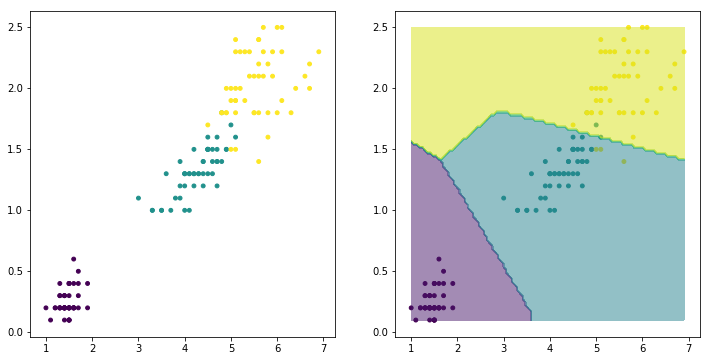

In [79]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__TODO__:
- evitar overflow das funções de ativação
- mini-batch SGD
- dropout
- early_stopping

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.